In [1]:
import tensorflow as tf
from tensorflow import reshape
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
#from data import load_image_h5
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import h5py
#import datetime
print(tf.__version__)

2.0.0


In [2]:
hf = h5py.File('simulated-attpc-events.h5', 'r')

In [3]:
image_width, image_length, image_channels = 128, 128, 3
image_shape = (128,128,3)

In [4]:
data = hf['features']
label = hf['targets']

In [5]:
#data.shape

In [6]:
train_data = data[0:40000]
test_data = data[40000:50000]
train_label = label[0:40000]
test_label = label[40000:50000]

In [7]:
from numpy import expand_dims
train_data=expand_dims(train_data, axis=3)
#train_data=np.concatenate((train_data)*3, axis=-1)
train_data.shape

(40000, 128, 128, 1)

In [8]:
train_data = np.concatenate((train_data,)*3, axis=-1)
#train_data = np.stack((train_data,)*3, axis=-1)
train_data.shape

(40000, 128, 128, 3)

In [9]:
train_data[0].shape

(128, 128, 3)

In [10]:
test_data=expand_dims(test_data, axis=3)
test_data.shape

(10000, 128, 128, 1)

In [11]:
test_data=np.concatenate((test_data,)*3, axis=-1)
test_data.shape

(10000, 128, 128, 3)

In [12]:
#Reshape data (https://www.machinecurve.com/index.php/2020/04/13/how-to-use-h5py-and-keras-to-train-with-data-from-hdf5-files/)

train_data = train_data.reshape((len(train_data), image_width, image_length, image_channels))
#test_data = test_data.reshape((len(test_data), image_width, image_length, image_channels))

In [13]:
#train_data[0]

In [14]:
#plt.figure(figsize=(10,10))
#for i in range(36):
#    plt.subplot(6,6,i+1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.grid(False)
#    plt.imshow(train_data[i], cmap=plt.cm.binary)
#    plt.xlabel(train_label[i])
#plt.show()

In [15]:
#Normalize
train_data = train_data/255.0
test_data = test_data/255.0

In [16]:
#Example from train_data
#train_data[0]
#plt.imshow(train_data[0])

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [18]:
#log_dir = "logs/fit/" + "CNN/VGG16" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 0)

In [19]:
vgg16_model = tf.keras.applications.VGG16(input_shape=image_shape, include_top=False, weights='imagenet')

In [20]:
vgg16_model.trainable=True

In [21]:
CNN_model = tf.keras.Sequential()
CNN_model.add(vgg16_model)
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(256, activation='relu'))
CNN_model.add(layers.Dropout(0.7))
CNN_model.add(layers.Dense(256, activation='relu'))
CNN_model.add(layers.Dropout(0.7))
CNN_model.add(layers.Dense(3, activation='softmax'))

CNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

In [22]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 7

In [23]:
CNN_history = CNN_model.fit(train_data, train_label, epochs=45,
                           batch_size=32,
                           shuffle=True,
                           callbacks = [callback],
                           validation_split=0.3)

Train on 28000 samples, validate on 12000 samples
Epoch 1/45
28000/28000 [==============================] - 76s 3ms/sample - loss: 1.2234 - accuracy: 0.4395 - val_loss: 0.6225 - val_accuracy: 0.8763
Epoch 2/45
28000/28000 [==============================] - 71s 3ms/sample - loss: 0.6010 - accuracy: 0.7425 - val_loss: 0.2584 - val_accuracy: 0.9275
Epoch 3/45
28000/28000 [==============================] - 73s 3ms/sample - loss: 0.3945 - accuracy: 0.8455 - val_loss: 0.1589 - val_accuracy: 0.9514
Epoch 4/45
28000/28000 [==============================] - 73s 3ms/sample - loss: 0.3004 - accuracy: 0.8893 - val_loss: 0.1165 - val_accuracy: 0.9588
Epoch 5/45
28000/28000 [==============================] - 74s 3ms/sample - loss: 0.2444 - accuracy: 0.9109 - val_loss: 0.0808 - val_accuracy: 0.9727
Epoch 6/45
28000/28000 [==============================] - 74s 3ms/sample - loss: 0.2056 - accuracy: 0.9281 - val_loss: 0.0659 - val_accuracy: 0.9778
Epoch 7/45
28000/28000 [==============================] 

In [24]:
result = CNN_model.evaluate(test_data, test_label, verbose=2)

10000/1 - 9s - loss: 0.2556 - accuracy: 0.9950


In [25]:
predictions = np.argmax(CNN_model.predict(test_data[:]),axis=1)

In [26]:
predictions.shape

(10000,)

In [27]:
#test_data[1]
#plt.imshow(test_data[1])

In [28]:
#predictions[1]

In [29]:
print(classification_report(test_label, predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3347
           1       1.00      1.00      1.00      3181
           2       0.99      0.99      0.99      3472

    accuracy                           0.99     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      0.99      1.00     10000



In [30]:
print(CNN_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


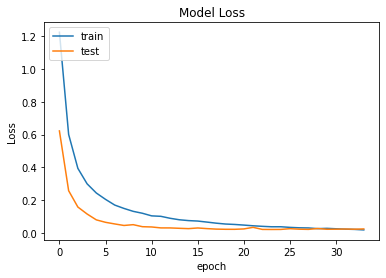

In [31]:
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model Loss')
#plt.yscale("log")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools

In [33]:
cm = confusion_matrix(test_label, predictions)

In [34]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         include_values=True,
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

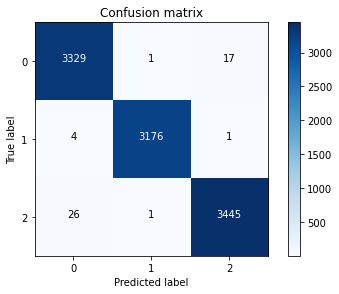

In [35]:
cm_plot_labels = ['0', '1', '2']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix')